In [70]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [327]:
import tensorflow as tf
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
%matplotlib inline

In [328]:
import sys
sys.path.append('..')
from dataset import batcher

In [329]:
MODEL_DIR = '../saved_models/'
LR_RATE = 0.001
OPT = tf.keras.optimizers.Adam(learning_rate=LR_RATE)
LOSS = 'MeanSquaredError'
METRICS = ['RootMeanSquaredError']

In [410]:
# Get test split
test_batcher = batcher.Batcher(bucket=False, shuffle=False, split='test', repeat=1, batch_size=652).get_dataset()
x_true = []
y_true = []
for x, y in test_batcher:
    x_true.append(x)
    y_true.append(y)

print(np.shape(x_true))

(1, 652, 224, 224, 1)


In [411]:
# Load model
experiments = ['imagery_sample_vgg_regression_100epoch']

def load_model_from_dir(model_name):
    model_path = MODEL_DIR + model_name + '.h5'
    model = tf.keras.models.load_model(model_path, compile=False)
    
    return model

In [412]:
# Get consumption predictions
trained_model = load_model_from_dir(experiments[0])
trained_model.compile(
            loss=LOSS,
            optimizer=OPT,
            metrics=METRICS,
        )

y_preds = trained_model.predict_on_batch(x_true)
print(y_preds)

2023-02-04 23:56:37.127529: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[[ 0.07218213]
 [ 0.10628061]
 [ 0.09708843]
 [ 0.09338503]
 [ 0.1669618 ]
 [ 0.12783039]
 [ 0.10921289]
 [ 0.09760724]
 [ 0.0800975 ]
 [ 0.09844247]
 [ 0.16641667]
 [ 0.04574908]
 [ 0.10100549]
 [ 0.10374562]
 [ 0.183078  ]
 [ 0.11988565]
 [ 0.09330063]
 [ 0.09698018]
 [ 0.10006294]
 [ 0.10048945]
 [ 0.09330063]
 [ 0.23773398]
 [ 0.09711584]
 [ 0.10277524]
 [ 0.09612265]
 [ 0.09982936]
 [ 0.62759876]
 [ 0.09929372]
 [ 0.10523646]
 [ 0.183078  ]
 [ 0.19864053]
 [ 0.09490591]
 [ 0.12713805]
 [ 0.29490364]
 [-0.01292007]
 [ 0.07867739]
 [ 0.06017214]
 [ 0.16044721]
 [ 0.10208413]
 [ 0.94258   ]
 [ 0.3219182 ]
 [ 0.11035255]
 [ 0.1561641 ]
 [ 1.5139694 ]
 [ 0.09698018]
 [ 0.08979794]
 [ 0.22154261]
 [ 0.09540232]
 [ 0.12713805]
 [ 0.09163427]
 [ 0.04735897]
 [ 0.16747457]
 [ 0.06232702]
 [ 0.09978593]
 [-0.00165167]
 [ 0.09949109]
 [ 0.14157242]
 [ 0.2432501 ]
 [ 0.09881557]
 [ 0.03459599]
 [ 0.10482397]
 [ 0.09011381]
 [ 0.89279664]
 [ 0.08645264]
 [ 0.13698137]
 [ 0.4060524 ]
 [-0.04761

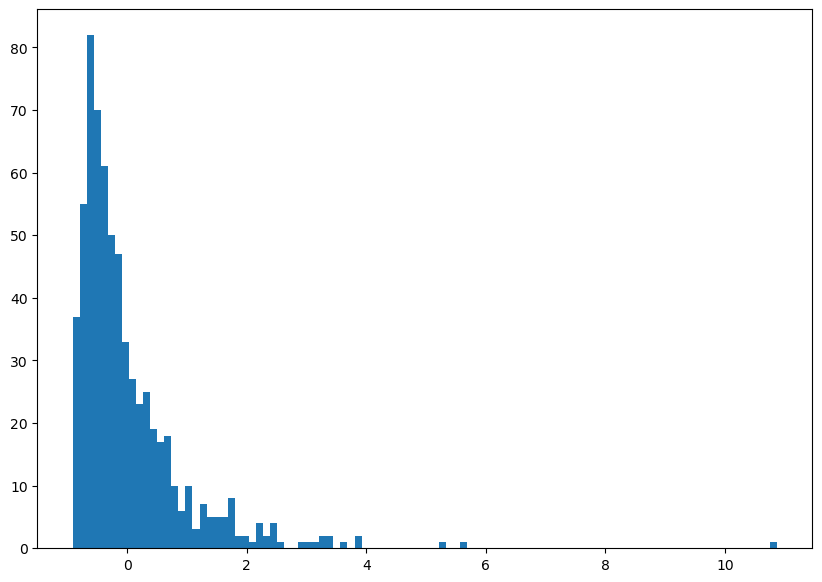

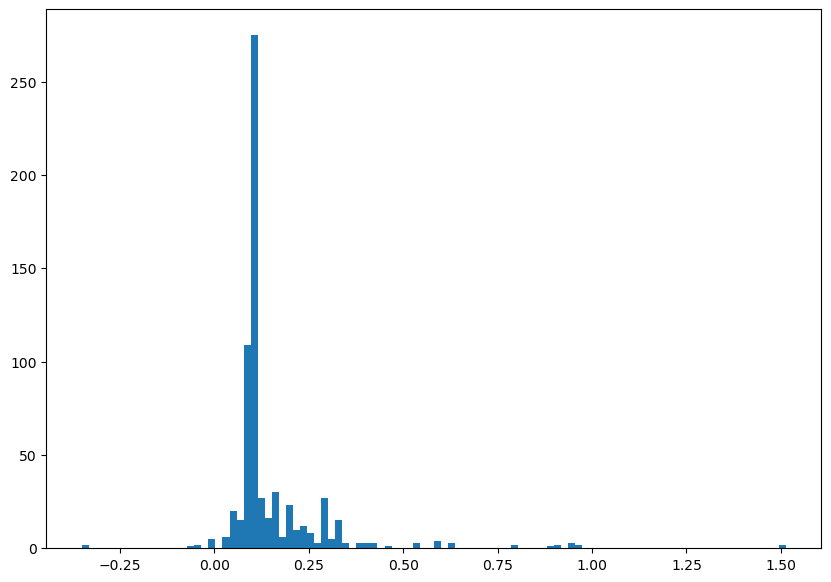

In [413]:
# Find r-squared
y_true = np.squeeze(y_true)
y_preds = np.squeeze(y_preds)

# Plot histograms
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(y_true, bins = 100)
plt.show()

fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(y_preds, bins = 100)
plt.show()


r2 = pearsonr(y_true, y_preds)[0]

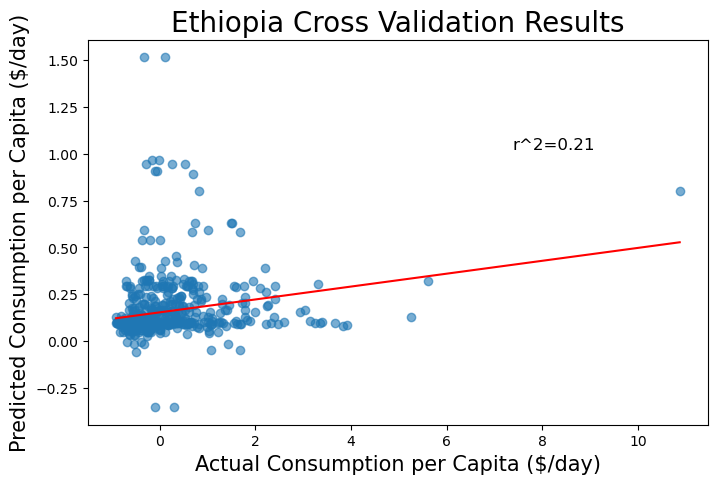

In [414]:
# Plot predictions
country = 'Ethiopia'
fig = plt.figure(figsize=(8,5))
plt.scatter(y_true, y_preds, alpha=0.6)
plt.plot(np.unique(y_true), np.poly1d(np.polyfit(y_true, y_preds, 1))(np.unique(y_true)), color='red')
plt.text(0.5, 0.5, f'r^2={round(r2, 2)}', ha='left', va='top', size=12, transform=ax.transAxes)
plt.xlabel('Actual Consumption per Capita ($/day)', fontsize=15)
plt.ylabel('Predicted Consumption per Capita ($/day)', fontsize=15)
plt.title(f'{country} Cross Validation Results', fontsize=20)
# plt.xlim([np.min(y_true), 10])
# plt.ylim([np.min(y_true), 10])
plt.show()